<a name="top"> <h1>3.4. Light GBM</h1> <a>

<p>Yelp Dataset- Stars Prediction<br />
<strong>Aprendizaje Autom&aacute;tico</strong><br />
<strong>Master Universitario en Ciencia de Datos</strong></p>

<p>&nbsp;</p>

<p style="text-align:right">Antonio Nogués Podadera (<em>antonio.nogues@cunef.edu</em>)</p>
<p style="text-align:right">V&iacute;ctor Viloria V&aacute;zquez (<em>victor.viloria@cunef.edu</em>)</p>

<hr style="border:1px solid gray">

[0. Introducción](#introduccion) 


[1. Importación de librerias y funciones](#librerias) 


[2. Carga de datos](#datos) 

[3. Creación del modelo](#creacion) 

   
[4. Optimización del modelo](#optimizacion) 

   
[5. Predicción del modelo](#prediccion)

[6. Evaluación de las métricas del modelo](#metricas)

   - Matriz de confusión
   - Métricas: Accuracy, Recall, Precision, F0.5, F1
   - Curva ROC y Lift

<hr style="border:1px solid gray">

# <a name="introduccion"> 0. Introducción <a> 


En este documento, nos centraremos en la creación de un **Modelo Light GBM**.


LightGBM es un método de ensamblaje de refuerzo de gradientes que se basa en árboles de decisión. Al igual que con otros métodos basados en árboles de decisión, LightGBM se puede utilizar tanto para la clasificación como para la regresión. LightGBM está optimizado para un alto rendimiento con sistemas distribuidos.




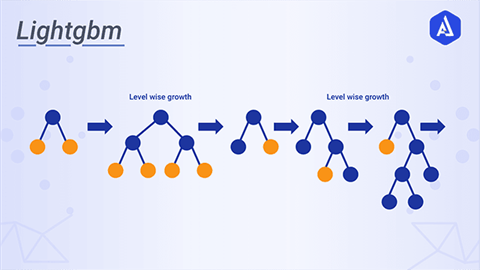

Una vez creado el modelo, procederemos a optimizarlo con los valores de train y predecir los valores de validación.


# <a name="librerias"> 1. Importación de librerias y funciones <a> 


Importamos las librerias necesarias para la creación y optimización del modelo XGBoost:

In [1]:
# Import basic libraries.

import pandas as pd
import matplotlib.pyplot as plt
import pickle 
import scikitplot as skplt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


# Import sklearn metrics.

from sklearn.metrics import plot_confusion_matrix, fbeta_score, roc_curve, classification_report,accuracy_score,roc_auc_score

# Import sklearn models, smote and pipeline.

from imblearn.pipeline import Pipeline
from sklearn.pipeline import Pipeline
import lightgbm as lgb

Importamos las funciones a utilizar:

In [2]:
# Import the functions used in the notebook.

from aux_functions import load_model, save_model

Cargamos el pickle de preprocesado, para su posterior uso:

In [3]:
# Import the preprocessor.

preprocessor = load_model('../models/preprocessor.pickle')

# <a name="datos"> 2. Carga de datos <a> 

En primer lugar procederemos a cargar los datos de train y validación que insertaremos dentro del modelo para su optimización y predicción.

In [4]:
# Load the train dataset separated by other variables and target. 

x_train = pd.read_parquet("../data/processed/x_train.parquet").reset_index(drop=True)
y_train = pd.read_parquet("../data/processed/y_train.parquet").reset_index(drop=True)

# Load the validation dataset separated by other variables and target. 

x_val = pd.read_parquet("../data/processed/x_val.parquet")
y_val = pd.read_parquet("../data/processed/y_val.parquet")

# <a name="creacion"> 3. Creación del modelo <a> 

Para la creación del modelo **LightGBM**  utilizaremos el algoritmo LGBMClassifier de la libreria _lightgbm_.

Creamos un Pipeline que ejecute el preprocesado primero y el algoritmo _LightGBM_ después.

Para el algoritmo designaremos los parámetros por default, pero utilizaremos todo el procesador para agilizar el proceso.

In [5]:
# Design the parameters.

n_jobs = -1
random_state = 12345

# Create a pipeline that applies a preprocess of the data and then the LogisticRegression model.

lightgbm_model = Pipeline([
    ('preprocessor', preprocessor),
    ('clasificador', lgb.LGBMClassifier(n_jobs=n_jobs, random_state=random_state)
    )
])


# <a name="optimizacion"> 4. Optimización del modelo <a> 

Optimizamos el modelo a través del pipeline creado anteriormente, para ello introduciremos los valores de train.

In [ ]:
# Optimization of the light_gbm with the train set: input and target data. 

lightgbm_model.fit(x_train, y_train)

Una vez optimizado el modelo XGB, con el set de train, procedemos a guardarlo en un pickle para que no se tenga que volver a computarlo en un futuro, por si quisieramos usarlo.

In [21]:
# Save the backup of the XGB optimziation as a pickle file.

save_model(lightgbm_model,'../models/lightgbm_model.pickle')

**Para evitar optimizar de nuevo el modelo, ejecutar a partir de la celda que aparece a continuación.**

In [8]:
# Load the XGB model already fitted in /models.

lightgbm_model = load_model('../models/lightgbm_model.pickle')


# <a name="prediccion"> 5. Predicción del modelo <a> 

Una vez realizada la optimización del modelo Light GBM, procederemos a predecir el set de validación, sus valores y probabilidades. Para posteriormente obtener las métricas y observar como se comporta el modelo y su score.

In [9]:
# Predict the target value of the validation set.

predictions = lightgbm_model.predict(x_val)

# Predict the probabilities of the target value for the validation set.

predict_probabilities = lightgbm_model.predict_proba(x_val)

Una vez obtenidas las probabilidades, representamos el histograma de densidad de la predicción:

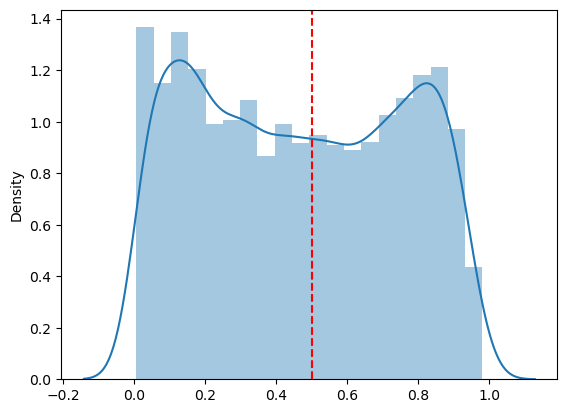

In [10]:
# Parametric density histogram of the predicted probabilities, shwoing the treshold of 0.5.

sns.distplot(predict_probabilities[:,1], kde=True, rug=False, bins=20)
plt.axvline(x=0.5, color='r', linestyle='--')
plt.show()


Observando el histograma de densidad de las probabilidades observamos como el modelo asigna a un mayor número de observaciones probabilidades bajas.

# <a name="metricas"> 6. Evaluación de las métricas del modelo <a> 

En este apartado procederemos a análizar las métricas obtenidas. Nos centraremos principalmente en la métrica F0.5 , dado que es la que mejor refleja los resultados del modelo para nuestro problema. En el caso de que se quiera consultar la definición de cada una de ellas, se pueden encontrar en el documento `02_DummyModel`. 

### 6.1. Matriz de confusión

Confusion matrix, without normalization
[[2648  777]
 [ 830 2217]]
Normalized confusion matrix
[[0.77313869 0.22686131]
 [0.27239908 0.72760092]]


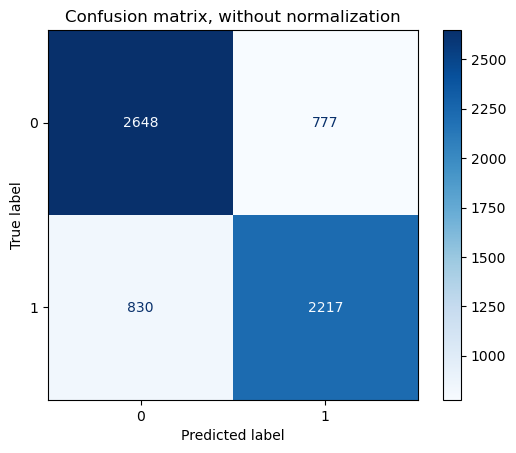

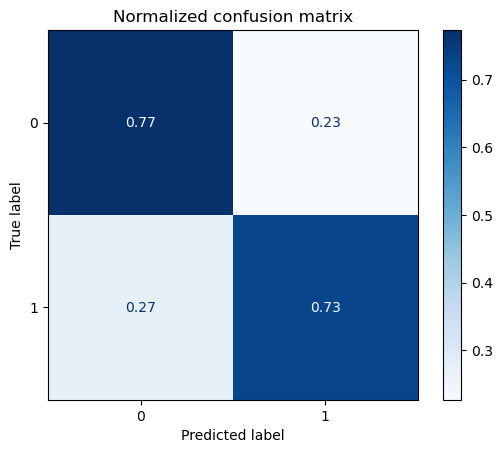

In [11]:
# List with the titles and parameters

titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]

# Plot the confusion matrix

for title, normalize in titles_options:
    disp = plot_confusion_matrix(lightgbm_model, x_val, y_val,
                                 # display_labels=ytest,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

Los resultados obtenidos nos permite afirmar que el modelo es capaz de identificar en un **73%** de los casos que un restaurante va a tener una puntuación alta, cometiendo un error de un **27%**. 

### 6.2. Métricas: Accuracy, Recall, Precision, F0.5 y F1.

In [26]:
# Print the general metrics.

print(classification_report(y_val, predictions))

              precision    recall  f1-score   support

           0       0.76      0.77      0.77      3425
           1       0.74      0.73      0.73      3047

    accuracy                           0.75      6472
   macro avg       0.75      0.75      0.75      6472
weighted avg       0.75      0.75      0.75      6472



In [12]:
# Model Accuracy

print("Accuracy:",accuracy_score(y_val, predictions))

# F 0.5 score.

print('F0.5 score is ' +str(fbeta_score(y_val, predictions, average='binary', beta=0.5)))

Accuracy: 0.7516996291718171
F0.5 score is 0.7378686014777341


Para poder reflejar la capacidad predictora del modelo utilizaremos el Accuracy y el Recall y F0.5 Score.

- El modelo nos calcula un **Recall de 0.75**, por lo que el modelo es capaz de identificar un 75% de casos en los que hay una valoración alta. 


- El modelo nos calcula un **Accuracy de 0.75**, por lo que el modelo es capaz de acertar en el 75% de los casos. 


- **El modelo nos calcula un F0.5 de 0.73, por lo que el modelo es capaz de diferenciar falsos positivos en el 73% de los casos. Supera por muy poco al RandomForest. Esta medida es la que utilizaremos para compararlo con el resto de modelos**


### 6.3. Curva ROC y Lift

Para evaluar nuestro modelo, la representaremos graficamente para deducir que tan bueno es el modelo.

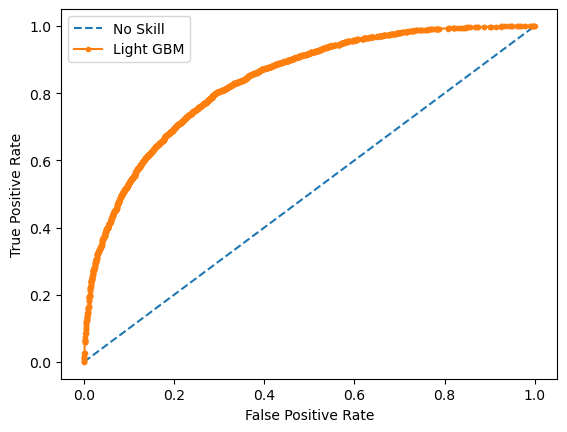

The Compute Area Under the Receiver Operating Characteristic is 0.8365649112804506


In [28]:
# Keep probabilities for the positive outcome only
yhat = predict_probabilities[:, 1]
# Calculate roc curves
fpr, tpr, thresholds = roc_curve(y_val, yhat)
# Plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Light GBM')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# Show the plot
plt.show()

# Display the ROC AUC.

print('The Compute Area Under the Receiver Operating Characteristic is '+ str(roc_auc_score(y_val,yhat)))

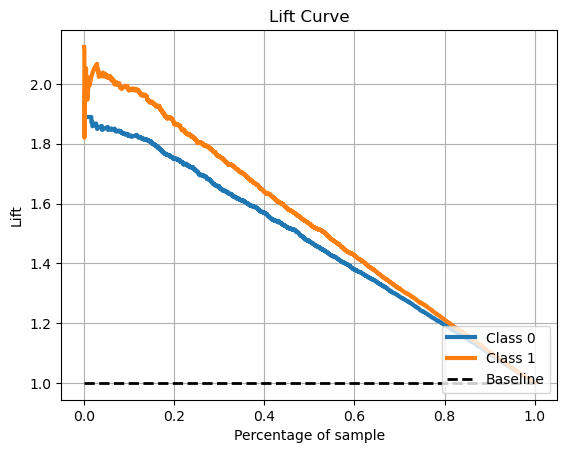

In [11]:
# Plot the lift curve.

skplt.metrics.plot_lift_curve(y_val, predict_probabilities)
plt.show()

 **La curva ROC muestra un resultado superior a los vistos anteriormente, pues el área bajo la curva es de 0.83.**

 En cuanto a la curva lift, podemos observar que el modelo es ligeramente superior tambien, puesto que la elevación comienza en un nivel algo más alto y va descendiendo hasta la linea de identidad con el 100% de muestra utilizado.

[Ir arriba del documento](#top)